In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/tmp/ipykernel_16758/1324450713.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [3]:
import csv
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def try_float(s):
    try:
        return float(s)
    except ValueError:
        return None

def str_to_float_encode(s):
    ord_strs = [ str(ord(c)) for c in s ]
    ord_str = ''.join(ord_strs) if ord_strs else '-1.0'
    return float(ord_str)

def str_to_float(s):
    f = try_float(s)
    return f if f is not None else str_to_float_encode(s)

In [106]:
#input_path = '../input/titanic/train.csv'
input_path = '../train.csv'

with open(input_path, 'r') as f:
    reader = csv.reader(f)
    _ = next(reader)
    samples = []
    targets = []

    for row in reader:
        target = int(row[1])
        targets.append(target)

        samp = [str_to_float(v) for v in row[2:]]
        samples.append(samp)
        #print(samp[3])

In [107]:
len(samples), len(samples[0])

(891, 10)

In [108]:
sample_tensor = torch.tensor(samples)
sample_ndarray = np.array(samples)
sample_df = pd.DataFrame(samples)

In [109]:
sample_df.nunique()

0      3
1    888
2      2
3     89
4      7
5      7
6    638
7    248
8    148
9      4
dtype: int64

In [110]:
counts = torch.unique(sample_tensor, dim=0)
counts

tensor([[ 1.0000e+00,  8.7101e+37,  1.0997e+10,  ...,  2.6550e+01,
         -1.0000e+00,  8.3000e+01],
        [ 1.0000e+00,         inf,  1.0997e+10,  ...,  2.9700e+01,
          6.7526e+05,  6.7000e+01],
        [ 1.0000e+00,         inf,  1.0997e+10,  ...,  3.0000e+01,
          6.8525e+05,  8.3000e+01],
        ...,
        [ 3.0000e+00,         inf,  1.0210e+16,  ...,  1.4500e+01,
         -1.0000e+00,  8.3000e+01],
        [ 3.0000e+00,         inf,  1.0210e+16,  ...,  3.4375e+01,
         -1.0000e+00,  8.3000e+01],
        [ 3.0000e+00,         inf,  1.0210e+16,  ...,  9.5875e+00,
         -1.0000e+00,  8.3000e+01]])

In [133]:
sample_tensor_modified = sample_tensor.clone()
sample_tensor_modified[:, 1] = torch.log(sample_tensor[:, 1]) # name -- this column is fucked, just get rid of it
sample_tensor_modified[:, 2] = torch.log(sample_tensor[:, 2]) # sex -- I guess I can log-ify it
sample_tensor_modified[:, 6] = torch.log(sample_tensor[:, 6]) # ticket -- logify it

original_col = sample_tensor[:, 8].clone()
modified_column = torch.log(original_col)
non_nan_mask = ~torch.isnan(modified_column)
sample_tensor_modified[:, 8] = torch.where(non_nan_mask, modified_column, original_col) # cabin -- logify it


max_float = torch.finfo(sample_tensor_modified.dtype).max
sample_tensor_modified[torch.isinf(sample_tensor_modified)] = max_float
sample_ndarray_modified = sample_tensor_modified.numpy()

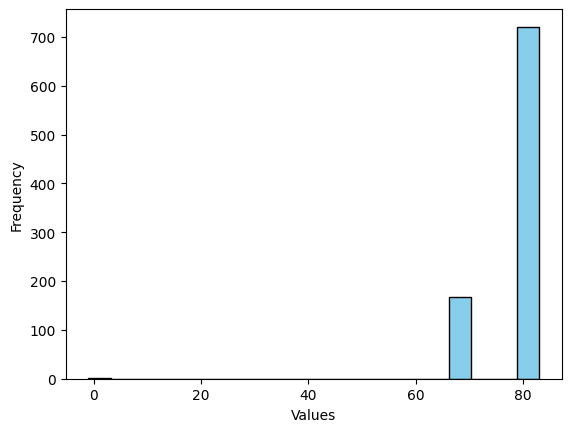

In [135]:
# Extract the column you want to visualize
column_to_visualize = sample_ndarray_modified[:, 9]  # Assuming you want to visualize the first column

# Plot the histogram
plt.hist(column_to_visualize, bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
#plt.title('Distribution of the First Column of the Tensor')

# Show the plot
plt.show()

In [136]:
sample_tensor_modified[:5]

tensor([[ 3.0000e+00,  3.4028e+38,  2.3121e+01,  2.2000e+01,  1.0000e+00,
          0.0000e+00,  4.1023e+01,  7.2500e+00, -1.0000e+00,  8.3000e+01],
        [ 1.0000e+00,  3.4028e+38,  3.6862e+01,  3.8000e+01,  1.0000e+00,
          0.0000e+00,  3.6627e+01,  7.1283e+01,  1.3423e+01,  6.7000e+01],
        [ 3.0000e+00,  3.4028e+38,  3.6862e+01,  2.6000e+01,  0.0000e+00,
          0.0000e+00,  7.3507e+01,  7.9250e+00, -1.0000e+00,  8.3000e+01],
        [ 1.0000e+00,  3.4028e+38,  3.6862e+01,  3.5000e+01,  1.0000e+00,
          0.0000e+00,  1.1642e+01,  5.3100e+01,  1.8028e+01,  8.3000e+01],
        [ 3.0000e+00,  3.4028e+38,  2.3121e+01,  3.5000e+01,  0.0000e+00,
          0.0000e+00,  1.2831e+01,  8.0500e+00, -1.0000e+00,  8.3000e+01]])

In [ ]:
def normalize(x):
    mean = torch.mean(x, dim=0)
    std = torch.std(x, dim=0)
    return (x - mean) / std

class MyDataset(Dataset):
    def __init__(self, features, targets):
        #tensorize = lambda x: torch.tensor(x, dtype=torch.float64)
        self.features = list(map(lambda x: torch.tensor(x, dtype=torch.float64), features))
        self.targets = list(map(lambda x: torch.tensor(x, dtype=torch.long), targets))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.targets[index]

norm_samps = normalize(torch.tensor(samples, dtype=torch.float64)).tolist()
my_dataset = MyDataset(norm_samps, targets)

train_size = int(0.85 * len(my_dataset))
eval_size = len(my_dataset) - train_size

train_dataset, eval_dataset = random_split(my_dataset, [train_size, eval_size])

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.leakyrelu = nn.LeakyReLU()
        self.l1 = nn.Linear(10, 128, dtype=torch.float64)
        self.l2 = nn.Linear(128, 128, dtype=torch.float64)
        self.l3 = nn.Linear(128, 128, dtype=torch.float64)
        self.l4 = nn.Linear(128, 128, dtype=torch.float64)
        self.l5 = nn.Linear(128, 128, dtype=torch.float64)
        self.l6 = nn.Linear(128, 64, dtype=torch.float64)
        self.l7 = nn.Linear(64, 32, dtype=torch.float64)
        self.l8 = nn.Linear(32, 16, dtype=torch.float64)
        self.l9 = nn.Linear(16, 8, dtype=torch.float64)
        self.l10 = nn.Linear(8, 4, dtype=torch.float64)
        self.l11 = nn.Linear(4, 2, dtype=torch.float64)

        init.xavier_uniform_(self.l1.weight)
        init.xavier_uniform_(self.l2.weight)
        init.xavier_uniform_(self.l3.weight)
        init.xavier_uniform_(self.l4.weight)
        init.xavier_uniform_(self.l5.weight)
        init.xavier_uniform_(self.l6.weight)
        init.xavier_uniform_(self.l7.weight)
        init.xavier_uniform_(self.l8.weight)
        init.xavier_uniform_(self.l9.weight)
        init.xavier_uniform_(self.l10.weight)
        init.xavier_uniform_(self.l11.weight)


    def forward(self, x):
        return self.l11(
            self.leakyrelu(self.l10(
            self.leakyrelu(self.l9(
            self.leakyrelu(self.l8(
            self.leakyrelu(self.l7(
            self.leakyrelu(self.l6(
            self.leakyrelu(self.l5(
            self.leakyrelu(self.l4(
            self.leakyrelu(self.l3(
            self.leakyrelu(self.l2(
            self.leakyrelu(self.l1(x)))))))))))))))))))))

# this should really be in Model
def predict(model, sample):
  predictions = model(sample).squeeze()
  best_i, best_prob = 0, predictions[0]
  for i in range(1, len(predictions)):
    if predictions[i] > best_prob:
        best_i, best_prob = i, predictions[i]
  return best_i

In [ ]:
model = Model()

In [ ]:
criterion = nn.CrossEntropyLoss()

lr = 0.000001
optimizer = optim.SGD(model.parameters(), lr=lr)

num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data in train_loader:
        ins, labels = data

        optimizer.zero_grad()

        outs = model(ins)
        #print(outs, labels)
        loss = criterion(outs, labels)
        #print(loss)
        #print(loss.size())
        #print(loss.shape)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1} loss: {epoch_loss}')

Epoch 1 loss: 180.57594671364873
Epoch 2 loss: 180.57487740862632
Epoch 3 loss: 180.57404728858185
Epoch 4 loss: 180.57285124136428
Epoch 5 loss: 180.57185187438066
Epoch 6 loss: 180.570647788244
Epoch 7 loss: 180.5698597826266
Epoch 8 loss: 180.5692789795778
Epoch 9 loss: 180.56835008978754
Epoch 10 loss: 180.56686304450898


In [ ]:
# print parameter count
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

78502


In [ ]:
# print sample and label of a random datapoint
for batch in train_loader:
    ins, lbls = batch
    print(ins)
    print(lbls)
    break

tensor([[-1.5652, -0.0000,  1.3548,  0.3582,  0.6814,  0.5601, -0.0842,  0.4827,
         -0.0474, -1.7321]], dtype=torch.float64)
tensor([1])


In [ ]:
# print params (before training)
for _, param in model.l1.named_parameters():
    print(param)

Parameter containing:
tensor([[-0.1882,  0.0417,  0.1344,  ..., -0.1266,  0.0709, -0.1948],
        [ 0.0809,  0.1979, -0.1637,  ...,  0.0078, -0.1980,  0.1443],
        [ 0.0949, -0.1445,  0.1798,  ...,  0.1913, -0.0129, -0.2070],
        ...,
        [-0.0589,  0.1539,  0.1891,  ...,  0.0033, -0.0295, -0.2041],
        [ 0.0160, -0.1946, -0.0840,  ..., -0.0329,  0.1356, -0.0375],
        [-0.1298,  0.0718, -0.1236,  ...,  0.1035, -0.0308, -0.1298]],
       dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([-0.1787, -0.0261, -0.0845, -0.2812,  0.2499,  0.1371, -0.0737, -0.1580,
        -0.2576, -0.2254,  0.1206,  0.0285, -0.0928,  0.1375, -0.2319, -0.2196,
         0.2096,  0.3126, -0.2185,  0.0242,  0.0511, -0.2590, -0.0502, -0.0126,
         0.2660,  0.2276,  0.2127, -0.1135,  0.1478,  0.0352, -0.0652, -0.2142,
         0.0649,  0.3095, -0.0339,  0.0113,  0.0727,  0.0459,  0.2704, -0.1651,
        -0.2444, -0.0033, -0.0086,  0.2405,  0.1585,  0.2560,  0.0291,  0.

In [ ]:
#print params (after training)
for _, param in model.l1.named_parameters():
    print(param)

Parameter containing:
tensor([[-0.4525,  0.0417,  0.5834,  ..., -0.2398,  0.0831, -0.2615],
        [ 0.0755,  0.1979, -0.1699,  ..., -0.0210, -0.1923,  0.1884],
        [ 0.1168, -0.1445,  0.2404,  ...,  0.2697, -0.0041, -0.1796],
        ...,
        [-0.1878,  0.1539,  0.2323,  ...,  0.0637, -0.0205, -0.3001],
        [-0.1156, -0.1946, -0.2763,  ...,  0.0172,  0.1264, -0.1373],
        [ 0.0087,  0.0718, -0.1556,  ...,  0.3245, -0.0283, -0.1450]],
       dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([-0.2973, -0.1476, -0.0966, -0.2427,  0.1541,  0.1073, -0.0707, -0.2312,
        -0.3669, -0.2362,  0.0332, -0.0434, -0.1305,  0.0500, -0.3289, -0.2467,
         0.1177,  0.0793, -0.1441, -0.1685,  0.0568, -0.2402, -0.1727,  0.0308,
         0.1898,  0.1037,  0.1362, -0.2224,  0.0298, -0.0240, -0.1450, -0.2501,
        -0.0015,  0.1393, -0.1146, -0.0233, -0.0379, -0.0090,  0.0997, -0.1843,
        -0.2788, -0.0118, -0.0062,  0.0936,  0.0836,  0.2171, -0.0619, -0.

In [ ]:
# print N examples of the model's predictions
N = 1
for i in range(N):
    for batch in train_loader:
        ins, lbls = batch
        out = model(ins)
        probs = torch.log(out)
        loss = criterion(model(ins), lbls)
        prediction = predict(model, ins)
        #loss = F.cross_entropy(out, lbls)
        #print(ins)
        print(f'sample {i+1}:')
        print(lbls)
        print(out)
        print(prediction)
        #print(probs)
        print(loss)
        print()
        break

sample 1:
tensor([0])
tensor([[ 2.1752, -8.6576]], dtype=torch.float64, grad_fn=<AddmmBackward0>)
0
tensor(1.9741e-05, dtype=torch.float64, grad_fn=<NllLossBackward0>)



In [ ]:
#EVAL

# MAX = 100
# i = 0
correct, total = 0, 0
for batch in eval_loader:
  # if i > MAX:
  #   break

  [s, t] = batch
  #print(f'target: {t.item()}\teval: {model(s)}\tpredict: {predict(model, s)}\t{correct}/{total}')
  correct, total = correct + (1 if predict(model, s) == t.item() else 0), total + 1

  # i = i + 1
print(f'{correct} correct out of {total}: {correct/total}%')

105 correct out of 134: 0.7835820895522388%


In [ ]:
input_path = '../input/titanic/test.csv'

with open(input_path, 'r') as f:
    reader = csv.reader(f)
    _ = next(reader)
    test_samples = []
    test_ids = []

    for row in reader:
        id = int(row[0])
        test_ids.append(id)

        samp = [str_to_float(v) for v in row[1:]]
        test_samples.append(samp)

In [ ]:
norm_test_samps = normalize(torch.tensor(test_samples, dtype=torch.float64)).tolist()
my_test_dataset = MyDataset(norm_test_samps, test_ids)
batch_size = 1
test_loader = DataLoader(my_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Opening the file in write mode with 'newline' parameter to avoid extra spacing
with open('submission1.csv', 'w', newline='') as csvfile:
    # Creating a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Writing the header row
    csv_writer.writerow(['PassengerId', 'Survived'])

    # Iterating through the test loader
    for batch in test_loader:
        # Extracting the features and IDs from the batch
        s, id = batch

        # Writing the ID and predicted value to the CSV file
        csv_writer.writerow([id.item(), predict(model, s)])

In [ ]:
!pwd

/content


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
model2 = Model()
model2.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [ ]:
#EVAL

# MAX = 100
# i = 0
correct, total = 0, 0
for batch in eval_loader:
  # if i > MAX:
  #   break

  [s, t] = batch
  #print(f'target: {t.item()}\teval: {model(s)}\tpredict: {predict(model, s)}\t{correct}/{total}')
  correct, total = correct + (1 if predict(model2, s) == t.item() else 0), total + 1

  # i = i + 1
print(f'{correct} correct out of {total}: {correct/total}%')

105 correct out of 134: 0.7835820895522388%
